# Function Approximation with a Multilayer Perceptron

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Approximation of 1D functions using a simple multilayer perceptron (MLP)
* Implementation of MLP using the Keras framework
* Implementation of MLP using core Tensorflow functions
* Approximation of 2D functions using a simple MLP with configurable number of hidden units

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

This code approximates a given 1D and later 2D function with a multilayer perceptron with a single hidden layer.

Select one of the given functions or add a new one.

Also select the activation function, which can be either `'tanh'` or `'relu'` 

In [2]:
activation_function = 'tanh'

function_select = 5

def myfun(x):
    functions = {
        1: np.power(x,2), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: (np.power(x,3)+ np.power(x-10,4))/np.power(x-20,2), # polynom
        6: 1+np.power(x,2)/4000-np.cos(x) # Griewank function
        # for Griewank, we need more than 50, does not generalize well (we must make sure not to have more parameters than samples in order to avoid overfitting)
    }
    return functions.get(function_select)


Define the range of the **training data** and of the final **evaluation data**. (they may differ)
The `batch_size` parameter defines how many examples we have in our training set

In [3]:
# Generate training data.
batch_size = 32
x_train = np.linspace(-1, 7, num=batch_size).reshape(-1,1)

# Generate the evaluation data. 
# (exceeds the range of the training data to evaluate the prediction capabilities)
x_eval = np.linspace(-3, 10, num=batch_size).reshape(-1,1) 


Create a **multilayer perceptron** with a single hidden layer and multiple inputs. The steps for creating the model are
1. Build the model. We use one dense layer followed by a linear readout layer. We use `tanh` as activation function, but you can change it to `relu` to see a different behavior using piecewise linear approximation.
2. Compile the model. We use the Adam (= Adaptive Moment Estimation) optimizer, which is a variant of the pure stochastic gradient descent optimizer optimized for improved convergence. The loss function is a mean squared error.
3. Train the model.

This MLP can be used both, for 1D and 2D functions.


In [4]:
def build_model(train_data, eval_data, labels, units, epochs):
    # Build the model.
    model = keras.Sequential()
    # change activation function between 'tanh' and 'relu' to see different effects
    model.add(keras.layers.Dense(units, input_dim=train_data.shape[1], kernel_initializer='he_normal', activation=activation_function))
    model.add(keras.layers.Dense(1, kernel_initializer='he_normal', activation='linear'))
    # Compile model
    model.compile(optimizer='adam', 
                  loss='mse',
                  metrics=['mse'])
    
    # Train the model.
    model.fit(train_data, labels, epochs=epochs, batch_size=np.size(train_data), verbose=0)
    
    # Calculate the prediction.
    return model.predict(eval_data, batch_size=np.size(eval_data))


To approximate the given function, we apply the following steps:
* **Generate training set**: This is a simple linspace in our case. (we already did this)
* **Preprocess the data**. We scale the data (X and Y) to a range of [-1,1] before feeding to the model.
* **Build**, **train** and **apply** the model.
* Postprocess the data. Then, we feed the evaluation dataset (which is different from the training dataset) into the model to show how well it generalizes


In [5]:
def approx_1d_function(x_train, x_eval, units, epochs): 
    # Generate labels for training data (here: the image of the selected function applied to X_train)
    y_train = myfun(x_train)
    # Scale the train data (x), the evaluation data (x_eval) and the labels (y) to the range [-1, 1].
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x_scaled = x_scaler.fit_transform(x_train)
    y_scaled = y_scaler.fit_transform(y_train)
    x_eval_scaled = x_scaler.transform(x_eval)
    
    # Build and apply multilayer perceptron.
    result = build_model(train_data=x_scaled, eval_data=x_eval_scaled, labels=y_scaled, units=units, epochs=epochs)
    
    # Rescale the result to original range.
    res_rescaled = y_scaler.inverse_transform(result)
    
    # Calculate the label (function value) for the evaluation training set.
    y_eval = myfun(x_eval)
    
    return x_eval, res_rescaled, y_eval

In [6]:
def plot_1d_function(x_train, x_eval, predictions, labels, units, epochs):
    fig = plt.figure(1, figsize=(18,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
    plt.plot(x_train, myfun(x_train), '.', color='royalblue')
    plt.grid(which='both');
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('%d neurons in hidden layer with %d epochs of training' % (units ,epochs))
    plt.legend(['Function f(x)', 'MLP output g(x)', 'Training set'])
    ax = fig.add_subplot(1, 2, 2)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, np.abs(predictions-myfun(x_eval)), '-', label='output', color='firebrick', linewidth=2.0)
    plt.grid(which='both');
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('Absolute difference between prediction and actual function')
    plt.legend(['Error |f(x)-g(x)|'])
    #plt.savefig('KerasMLP_%d_neurons.pdf' % units, bbox_inches='tight')
    plt.show()        

Finally, carry out the approximation of the function and plot results.

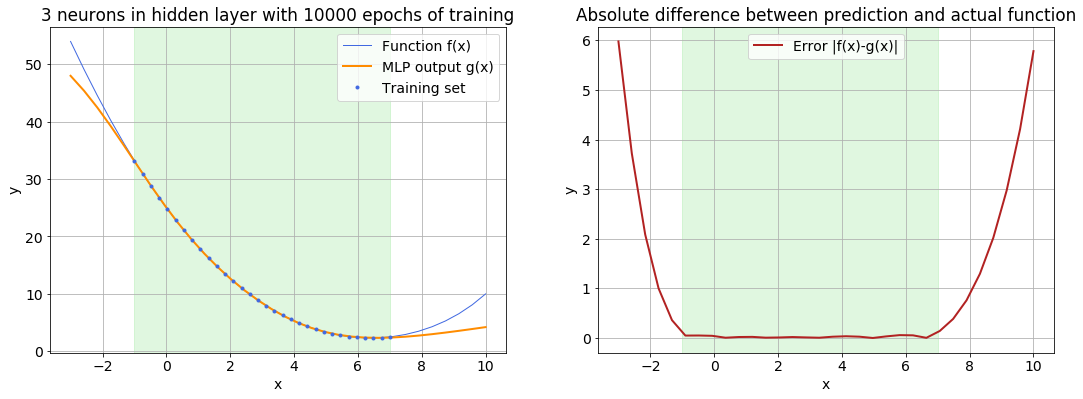

In [10]:
units = 3
epochs = 10000
x, predictions, labels = approx_1d_function(x_train=x_train, x_eval=x_eval, units=units, epochs=epochs)
plot_1d_function(x_train,x_eval,predictions,labels, units, epochs)

## Function approximation in 2D 
Our training data is now a meshgrid of x,y values.  
Select one of the given two functions below or add a new one by yourself

In [25]:
fun_2d = 2

def my2dfun(x1, x2):
    functions = {
        1: np.power(x1,2)+np.power(x2,2), # quadratic function
        2: np.sin(np.sqrt(x1**2 + x2**2)) # sinus
    }
    return functions.get(fun_2d)

Generate **training data**, use `batch_size` entries in each dimension.


In [26]:
batch_size = 16 # Number of grid steps per dimension (batch_size**2 equals number of training samples).
x1 = np.linspace(-3.0, 3.0, num=batch_size).reshape(-1,1)
x2 = np.linspace(-3.0, 3.0, num=batch_size).reshape(-1,1)


In [27]:
def plot_2d_function(X1, X2, Y, res):    
    fig = plt.figure(1,figsize=(24,12))
    plt.rcParams.update({'font.size': 18})
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), Y.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(X1, X2, Y, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Function.')
    ax = fig.add_subplot(2,3, 2, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), res.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(X1, X2, res, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Prediction.')
    ax = fig.add_subplot(2,3, 3, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), np.abs(res-Y).flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 6)
    im = ax.contourf(X1, X2, np.abs(res-Y), levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Absolute difference between \n prediction and actual function')
    #plt.savefig('2d_fun%d_units%d.pdf' % (fun_2d, units),bbox_inches='tight')

For the approximation of the 2D function, our training set is a meshgrid.  
After preparation of the data, we can feed the data to the model.   
Note that we use the **same model** as above for the 1D function.
The only difference is the shape of the training elements. (In the 1D case, each element was an $x$-value, labelled 
with the return value of the function $f(x)$. Now each element is a vector $\boldsymbol{x}=\begin{pmatrix}x_1 & x_2\end{pmatrix}$, labelled with the return value of the function $f(\boldsymbol{x})$.)


In [28]:
def approx_2d_function(x1_train, x2_train, units, epochs):
    X1, X2 = np.meshgrid(x1_train, x2_train)
    # Generate labels.
    Y = my2dfun(X1, X2).reshape(-1,1)
    
    # Scale X1 and X2 values to the range [-1, 1]. 
    x1_scaler = MinMaxScaler(feature_range=(-1, 1))
    x2_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x1_scaled = x1_scaler.fit_transform(x1_train)
    x2_scaled = x2_scaler.fit_transform(x2_train)
    y_scaled = y_scaler.fit_transform(Y)
    X1_scaled, X2_scaled = np.meshgrid(x1_scaled, x2_scaled)
    cord = np.stack((X1_scaled, X2_scaled), axis=-1).reshape(batch_size**2, 2)
    
    result = build_model(train_data=cord, eval_data=cord, labels=y_scaled, units=units, epochs=epochs)

    # Rescale data to original range.
    res_rescaled = y_scaler.inverse_transform(result)
    return res_rescaled.reshape(batch_size, batch_size)

Approximate function using the MLP and plot results.


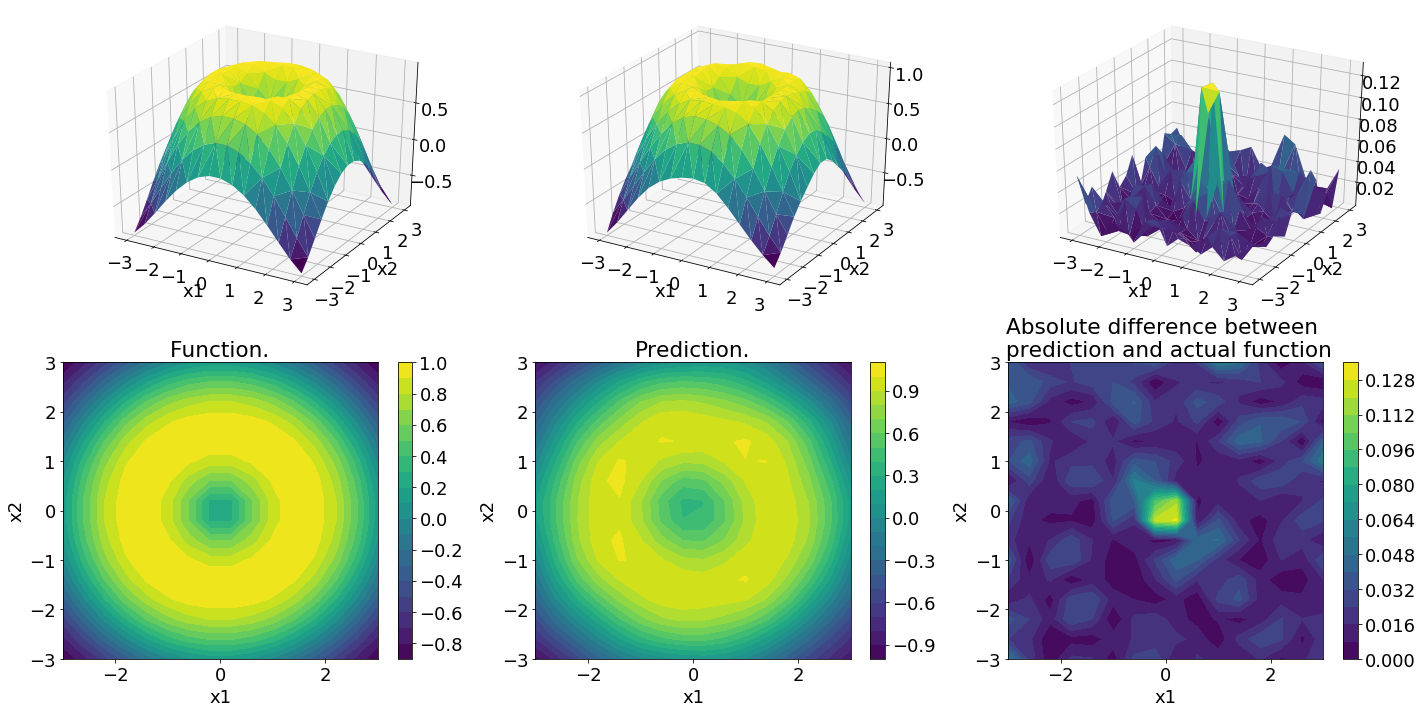

In [33]:
units = 10
epochs = 20000
res = approx_2d_function(x1, x2, units, epochs)
X1,X2 = np.meshgrid(x1,x2)
Y = my2dfun(X1,X2)
plot_2d_function(X1,X2,Y,res)


## Function Approximation with (basic) Tensorflow
Until now, we used Tensorflow with a high-level API, called Keras. This worked fine for our problem, 
but it can be useful to understand what is going on behind this API.
Therefore, in the following code we reimplement our multilayer perceptron with basic, pure Tensorflow code.
This will give you a glimpse into the world of Tensorflow. For more detailled information visit the 
[TF-Guide](https://www.tensorflow.org/guide) or wait for the upcoming MLOC jupyter notebooks 😉.

In [55]:
function_select = 2

def tf_fun(x):
    functions = {
        1: tf.pow(x,2), # quadratic function
        2: tf.sin(x), # sinus
        3: tf.sign(x), # signum
        4: tf.exp(x), # exponential function
        5: (tf.pow(x,3)+ tf.pow(x-10,4))/tf.pow(x-20,2), # polynom
        6: 1+tf.pow(x,2)/4000-tf.cos(x) # Griewank function
    }
    return functions.get(function_select)


Create Tensorflow computation graph. A tf graph is a series of tf operations arranged into a graph.  
This graph contains nodes ([tf.Operation](https://www.tensorflow.org/api_docs/python/tf/Operation) -> consumes and produces tensors) 
and edges ([tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) -> values that flow through the graph).

In [30]:
# MLP with single hidden layer and multiple inputs
def build_model_pure_tensorflow(batch_size, units, epochs):       
    graph = tf.Graph()
    with graph.as_default():
        
        # Generate training set. X values just uniformly sampled points between -8 and 8
        x = tf.expand_dims(tf.linspace(-8.0, 8.0, batch_size), axis=1)
        # The labels, here, we use a function that we would like to approximate.     
        labels = tf_fun(x)
        
        # Hidden Layer with three inputs and tanh activation function.
        # W and b are matrices and vectors definining what is going on in the neurons, respectively.
        # The inputs are initialized with a standard normal distribution.
        W = tf.get_variable('W', shape=[1,units], dtype=tf.float32, initializer=tf.random_normal_initializer(0,1))
        b = tf.get_variable('b', shape=[1,units], dtype=tf.float32, initializer=tf.random_normal_initializer(0,1))
        h = tf.tanh(tf.matmul(x, W) + b)         
                       
        # Output layer is just weighted addition of the outputs of the neurons.
        v = tf.get_variable('v', shape=[units,1], dtype=tf.float32, initializer=tf.random_normal_initializer(0,1))
        predictions =tf.matmul(h, v)       
        
        # Mean-squared error as a loss criterion.
        loss = tf.losses.mean_squared_error(labels, predictions) 
        
        # The train step is a simple Gradient Descent with step size 0.001.
        #train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(loss)
        # Doesn't converge too well, so we better use Adam.
        train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
        
        # Initialize all variables.
        init = tf.global_variables_initializer()
    
    # Create a session on graph and initialize all variables. 
    # This instantiates a session and evaluates the tensors (runs graph).
    # During one run(), any tensor has a single fixed value (random vars are just 'diced' with each new call of run()).
    sess = tf.Session(graph=graph)
    sess.run(init)
    
    # SGD loop, 100000x run a training step.
    for i in range(epochs):
        sess.run(train_step)
    
    # Return predictions and hidden activations.
    return sess.run([x, predictions, labels])


Specify model parameters and run model.

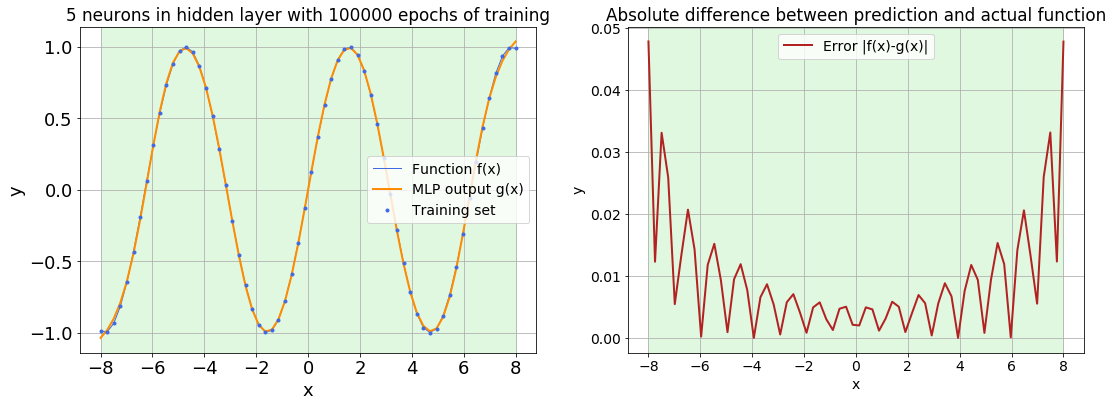

In [31]:
batch_size = 64 # Length of training vector.
units = 5
epochs = 100000
   
params = build_model_pure_tensorflow(batch_size, units, epochs)
x, predictions, labels = params
plot_1d_function(x.flatten(), x.flatten(), predictions.flatten(), labels.flatten(), units, epochs)
